# Universidad de O'Higgins

## Escuela de Ingeniería
## COM4402: Introducción a Inteligencia Artificial

### **Tarea 2: Clasificación de Dígitos Manuscritos con Redes Neuronales**

### Estudiante: Ingrese su nombre y apellido

El objetivo de esta tarea es utilizar redes neuronales en un problema de clasificación de dígitos. Se utilizará el conjunto de datos Optical Recognition of Handwritten Digits Data Set. Este conjunto tiene 64 características, con 10 clases y 5620 muestras en total. La base de datos estará disponible en U-Campus.

Las redes a ser entrenadas tienen la siguiente estructura: capa de entrada de dimensionalidad 64 (correspondiente a los datos de entrada), capas ocultas (una o dos) y capa de salida con 10 neuronas y función de activación softmax. La función de loss (pérdida) es entropía cruzada. El optimizador que se
debe usar es Adam. La función softmax está implícita al usar la función de pérdida CrossEntropyLoss de PyTorch (**no se debe agregar softmax a la salida de la red**).

Se usará PyTorch para entrenar y validar la red neuronal que implementa el clasificador de dígitos. Se analizará los efectos de cambiar el tamaño de la red (número de capas ocultas y de neuronas en estas
capas) y la función de activación.

El siguiente código base debe ser usado para realizar las actividades pedidas.

## Observación: Antes de ejecutar su código, active el uso de GPU en Google Colab para acelerar el proceso de entrenamiento.

### Para esto: vaya a "Entorno de Ejecución" en el menú superior, haga click en "Cambiar tipo de entorno de ejecución", y seleccionar/verificar "GPU" en "Acelerador de Hardware"

In [3]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Subir datasets de dígitos (train)

In [4]:
!wget raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_train.txt
!wget raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_test.txt

--2023-10-28 17:33:05--  http://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_train.txt [following]
--2023-10-28 17:33:05--  https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_train.txt
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 640604 (626K) [text/plain]
Saving to: ‘1_digits_train.txt’

1_digits_train.txt  100%[===================>] 625.59K  --.-KB/s    in 0.006s  

2023-10-28 17:33:05 (97.1 MB/s) - ‘1_digits_train.txt’ saved [640604

## Leer dataset de dígitos

In [5]:
column_names = ["feat" + str(i) for i in range(64)]
column_names.append("class")

In [6]:
df_train_val = pd.read_csv('1_digits_train.txt', names = column_names)
df_train_val

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4342,0,0,9,11,0,0,0,0,0,7,...,0,0,0,8,12,12,15,10,0,2
4343,0,0,6,15,2,0,0,0,0,0,...,0,0,0,7,16,16,10,1,0,6
4344,0,0,15,16,16,14,0,0,0,0,...,0,0,0,14,11,0,0,0,0,7
4345,0,0,0,1,15,11,0,0,0,0,...,0,0,0,0,1,16,10,0,0,4


In [7]:
df_test = pd.read_csv('1_digits_test.txt', names = column_names)
df_test

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,13,12,10,12,8,0,0,2,...,0,0,0,10,16,16,8,0,0,5
1,0,0,8,16,14,4,0,0,0,5,...,0,0,0,10,16,14,12,2,0,9
2,0,0,0,7,16,0,0,0,0,0,...,0,0,0,0,9,15,1,0,0,4
3,0,0,2,14,9,2,0,0,0,0,...,0,0,0,2,14,14,2,0,0,0
4,0,1,16,16,15,3,0,0,0,0,...,0,0,0,16,6,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,0,0,5,13,11,2,0,0,0,2,...,0,0,0,8,13,15,10,1,0,9
1268,0,0,0,1,12,1,0,0,0,0,...,0,0,0,0,4,9,0,0,0,4
1269,0,0,3,15,0,0,0,0,0,0,...,0,0,0,4,14,16,9,0,0,6
1270,0,0,6,16,2,0,0,0,0,0,...,0,0,0,5,16,16,16,5,0,6


In [8]:
df_train, df_val = train_test_split(df_train_val, test_size = 0.3, random_state = 10)

In [9]:
scaler = StandardScaler().fit(df_train.iloc[:,0:64])
df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
df_test.iloc[:,0:64] = scaler.transform(df_test.iloc[:,0:64])

<ipython-input-9-9f48500b620a>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
<ipython-input-9-9f48500b620a>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
<ipython-input-9-9f48500b620a>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns

In [10]:
df_train

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
4026,0.0,-0.338570,0.797238,0.535297,-0.599203,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,-0.302452,0.078492,-0.427291,0.468026,1.548367,0.696964,-0.186744,9
1548,0.0,-0.338570,-0.269346,0.999221,0.985819,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.121990,0.248408,0.876852,1.378118,-0.527715,-0.186744,3
1709,0.0,-0.338570,-0.482663,0.535297,0.759387,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.723436,-0.427291,0.876852,1.548367,-0.037843,-0.186744,1
2195,0.0,2.026364,1.863823,-0.392551,-2.410657,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,1.890776,1.481867,-0.652523,-0.758451,0.356618,1.186836,-0.186744,2
1216,0.0,2.026364,0.797238,0.767259,0.985819,1.661897,0.191388,-0.13043,-0.045374,2.953365,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.672439,0.356618,-0.282779,-0.186744,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009,0.0,-0.338570,-1.122613,-2.248248,-0.599203,1.839863,0.493359,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-1.124400,-2.679617,0.468026,-0.664881,-0.527715,-0.186744,9
1180,0.0,0.843897,0.583922,-0.392551,0.532956,0.772065,-0.412556,-0.13043,-0.045374,3.278195,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.468026,0.867368,0.452028,-0.186744,3
3441,0.0,-0.338570,-0.269346,-0.160589,0.985819,0.950031,-0.110584,-0.13043,-0.045374,0.354728,...,-0.206188,0.0,-0.302452,0.078492,0.473640,-2.393755,-1.175631,-0.527715,-0.186744,9
1344,0.0,-0.338570,1.223872,0.999221,0.985819,0.238166,-0.412556,-0.13043,-0.045374,0.029899,...,0.911859,0.0,-0.302452,0.880421,0.924106,0.876852,1.548367,3.391260,6.008192,2


## Crear modelo

In [11]:
model = nn.Sequential(
          nn.Linear(64, 10),
          nn.ReLU(),
          nn.Linear(10,10)
        )

In [12]:
device = torch.device('cuda')

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Crear datasets y dataloaders para pytorch (train)

In [13]:
# Crear datasets
feats_train = df_train.to_numpy()[:,0:64].astype(np.float32)
labels_train = df_train.to_numpy()[:,64].astype(int)
dataset_train = [ {"features":feats_train[i,:], "labels":labels_train[i]} for i in range(feats_train.shape[0]) ]

feats_val = df_val.to_numpy()[:,0:64].astype(np.float32)
labels_val = df_val.to_numpy()[:,64].astype(int)
dataset_val = [ {"features":feats_val[i,:], "labels":labels_val[i]} for i in range(feats_val.shape[0]) ]

feats_test = df_test.to_numpy()[:,0:64].astype(np.float32)
labels_test = df_test.to_numpy()[:,64].astype(int)
dataset_test = [ {"features":feats_test[i,:], "labels":labels_test[i]} for i in range(feats_test.shape[0]) ]

In [14]:
# Crear dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)

## Entrenamiento

In [15]:
start = time.time()

# loop over the dataset multiple times
for epoch in range(250):
  model.train()
  # Train on the current epoch
  for i, data in enumerate(dataloader_train, 0):
    # Process the current batch
    inputs = data["features"].to(device)
    labels = data["labels"].to(device)
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward() # backpropagation
    optimizer.step()

    # Por completar: calcule la pérdida de validación y acurracy en el batch actual

    _, predicted = torch.max(outputs, 1)
    correct_train = (predicted == labels).sum().item()
    accuracy_train = correct_train / len(labels)






  model.eval()
  total_val_loss = 0
  correct_val = 0
  total_val = 0
  with torch.no_grad():
    # Por completar: calcule la pérdida de validación y acurracy en la época actual
   for data in dataloader_val:
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)
            outputs = model(inputs)

            loss_val = criterion(outputs, labels)
            total_val_loss += loss_val.item()

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
  accuracy_val = correct_val / total_val
  average_val_loss = total_val_loss / len(dataloader_val)


  # Por hacer: imprima la pérdida de entrenamiento/validación y acurracy en la época actual
  #print('epoch %d' % (epoch))
  print(f'Epoch {epoch}, Train Loss: {loss.item():.4f}, Train Acc: {accuracy_train:.4f}, Val Loss: {average_val_loss:.4f}, Val Acc: {accuracy_val:.4f}')

end = time.time()
print('Finished Training, total time %f seconds' % (end - start))

Epoch 0, Train Loss: 2.2285, Train Acc: 0.1939, Val Loss: 2.1738, Val Acc: 0.2628
Epoch 1, Train Loss: 1.9815, Train Acc: 0.4796, Val Loss: 1.9825, Val Acc: 0.4084
Epoch 2, Train Loss: 1.7992, Train Acc: 0.5816, Val Loss: 1.7707, Val Acc: 0.6084
Epoch 3, Train Loss: 1.6113, Train Acc: 0.6837, Val Loss: 1.5280, Val Acc: 0.7027
Epoch 4, Train Loss: 1.3987, Train Acc: 0.6837, Val Loss: 1.3138, Val Acc: 0.7241
Epoch 5, Train Loss: 1.1804, Train Acc: 0.7143, Val Loss: 1.1356, Val Acc: 0.7479
Epoch 6, Train Loss: 0.9816, Train Acc: 0.8163, Val Loss: 0.9741, Val Acc: 0.7985
Epoch 7, Train Loss: 0.8843, Train Acc: 0.8265, Val Loss: 0.8404, Val Acc: 0.8161
Epoch 8, Train Loss: 0.6940, Train Acc: 0.8265, Val Loss: 0.7612, Val Acc: 0.8276
Epoch 9, Train Loss: 0.7543, Train Acc: 0.8061, Val Loss: 0.6505, Val Acc: 0.8337
Epoch 10, Train Loss: 0.5369, Train Acc: 0.8469, Val Loss: 0.5807, Val Acc: 0.8452
Epoch 11, Train Loss: 0.6259, Train Acc: 0.8265, Val Loss: 0.5339, Val Acc: 0.8544
Epoch 12, Trai

In [16]:



from sklearn.metrics import confusion_matrix, accuracy_score

#Primero definimos algunas funciones para graficar y generar las matrices

import matplotlib.pyplot as plt

def plot_loss(train_losses, val_losses):
    plt.plot(train_losses, label='Entrenamiento Loss')
    plt.plot(val_losses, label='Validacion Loss')
    plt.xlabel('Epocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()




#Aca definimos la parte c y d , en donde se genera la matriz de confusion normalizada y el accuracy
#Lo hacemos de esta manera para no tener que modificar el codigo tantas veces.

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

def compute_confusion_matrix_and_accuracy(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in dataloader:
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, normalize='true')
    acc = accuracy_score(all_labels, all_preds)
    return cm, acc
#Aca ploteamos los resultados para obtener una clarificacion de los resultados obtenidos
def plot_confusion_matrix(cm):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()


In [17]:
#PARTE A

#Definimos algunas listas para ir guardando los resultados, esto nos servira mientras avanzamos en la tarea y tambien para la parte 3
lista_accuracies = []
train_accuracies_a = []
train_losses_a = []
val_losses_a = []
val_accuracies_a = []
# aca definimos la red neuronal
class NeuralNetA(nn.Module):
    def __init__(self):
        super(NeuralNetA, self).__init__()
        self.layer1 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(10, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x
#Creamos modelo
model_a = NeuralNetA().to(device)


In [18]:
#implementamos que se detenga el entrenamiento cuando el loss de validacion comience a aumentar mientras que el de entrenamiento siga bajando.

optimizer = torch.optim.Adam(model_a.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

num_epochs = 1000
patience = 20  # Número de épocas para esperar antes de detener el entrenamiento
best_val_loss = float('inf')
epochs_no_improve = 0

start = time.time()

for epoch in range(num_epochs):
    # Aca el Entrenamiento
    model_a.train()
    running_train_loss = 0.0
    correct_train_preds = 0
    total_train_samples = 0
    for data in dataloader_train:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        optimizer.zero_grad()
        outputs = model_a(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        running_train_loss += loss.item()
        correct_train_preds += (preds == labels).sum().item()
        total_train_samples += labels.size(0)
        loss.backward()
        optimizer.step()

    average_train_loss = running_train_loss / len(dataloader_train)
    train_accuracy = correct_train_preds / total_train_samples
    train_losses_a.append(average_train_loss)
    train_accuracies_a.append(train_accuracy)









    # Creamos la parte de validación
    model_a.eval()
    val_loss = 0.0
    correct_val_preds = 0
    total_val_samples = 0
    with torch.no_grad():
        for data in dataloader_val:
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)
            outputs = model_a(inputs)
            loss_val = criterion(outputs, labels)
            val_loss += loss_val.item()
            _, preds = torch.max(outputs, 1)
            correct_val_preds += (preds == labels).sum().item()
            total_val_samples += labels.size(0)

    average_val_loss = val_loss / len(dataloader_val)
    val_accuracy = correct_val_preds / total_val_samples

    # Guardamos los resultados
    train_losses_a.append(average_train_loss)
    train_accuracies_a.append(train_accuracy)
    val_losses_a.append(average_val_loss)
    val_accuracies_a.append(val_accuracy)



    # Calculamos el accuracy de validación para esta época
    _, acc_val_current = compute_confusion_matrix_and_accuracy(model_a, dataloader_val)
    lista_accuracies.append(acc_val_current)


    # Verificamos si el loss de validación ha mejorado
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1




    # Si el loss de validación no mejora durante 'patience' epocas, detener el entrenamiento
    if epochs_no_improve == patience:
        print(f"Early stopping en epoca {epoch}")
        break

    print(f'Epoch {epoch}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {average_val_loss:.4f}, Val Accuracy: {acc_val_current:.4f}')
    train_losses_a.append(loss.item())
    val_losses_a.append(average_val_loss)

end = time.time()

print('Entrenamiento finalizado, total tiempo %f seconds' % (end - start))#Printeamos el tiempo
# Cálculo del accuracy de validación para model_a
_, acc_val_a = compute_confusion_matrix_and_accuracy(model_a, dataloader_val)
print(f"Validation Accuracy for model_a: {acc_val_a:.4f}")







Epoch 0, Train Loss: 2.2584, Train Accuracy: 0.1335, Val Loss: 2.1420, Val Accuracy: 0.2835
Epoch 1, Train Loss: 2.0558, Train Accuracy: 0.3675, Val Loss: 1.9255, Val Accuracy: 0.4766
Epoch 2, Train Loss: 1.8524, Train Accuracy: 0.5095, Val Loss: 1.7247, Val Accuracy: 0.5709
Epoch 3, Train Loss: 1.6548, Train Accuracy: 0.5750, Val Loss: 1.5327, Val Accuracy: 0.6230
Epoch 4, Train Loss: 1.4698, Train Accuracy: 0.6226, Val Loss: 1.3505, Val Accuracy: 0.6559
Epoch 5, Train Loss: 1.2946, Train Accuracy: 0.6775, Val Loss: 1.2053, Val Accuracy: 0.7073
Epoch 6, Train Loss: 1.1387, Train Accuracy: 0.7127, Val Loss: 1.0461, Val Accuracy: 0.7333
Epoch 7, Train Loss: 0.9945, Train Accuracy: 0.7459, Val Loss: 0.9174, Val Accuracy: 0.7678
Epoch 8, Train Loss: 0.8760, Train Accuracy: 0.7847, Val Loss: 0.8010, Val Accuracy: 0.8061
Epoch 9, Train Loss: 0.7710, Train Accuracy: 0.8225, Val Loss: 0.7137, Val Accuracy: 0.8391
Epoch 10, Train Loss: 0.6870, Train Accuracy: 0.8567, Val Loss: 0.6467, Val Accu

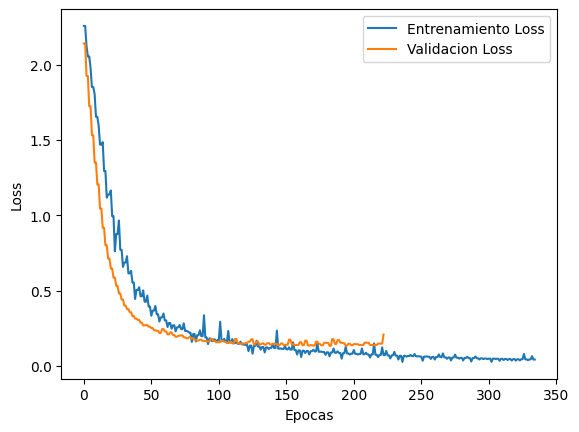

Training Accuracy: 0.9921


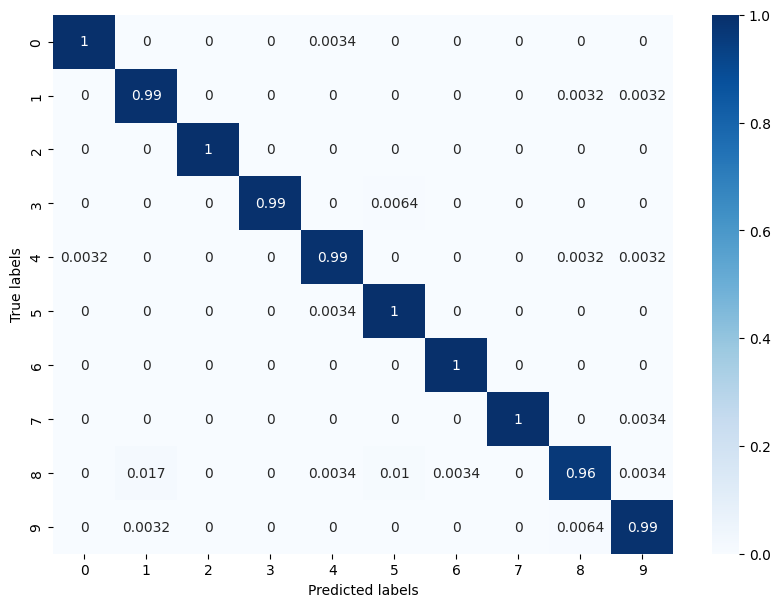

Validation Accuracy: 0.9678


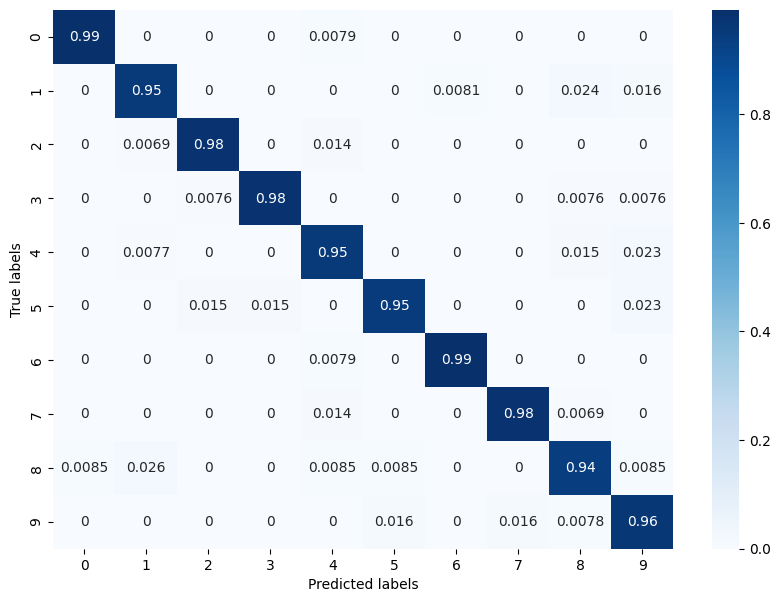

In [19]:
# (b) Graficamos el loss de entrenamiento y validación
plot_loss(train_losses_a, val_losses_a)

# (c) Generamos la matriz de confusión y accuracy para el conjunto de entrenamiento
cm_train, acc_train = compute_confusion_matrix_and_accuracy(model_a, dataloader_train)
print(f"Training Accuracy: {acc_train:.4f}")
plot_confusion_matrix(cm_train)

# (d) Generamos la matriz de confusión y accuracy para el conjunto de validación
cm_val, acc_val = compute_confusion_matrix_and_accuracy(model_a, dataloader_val)
print(f"Validation Accuracy: {acc_val:.4f}")
plot_confusion_matrix(cm_val)


In [21]:
# B)
#Basicamente repetimos todos los pasos anteriores, para no tener que comentar todo , en pocas palabras solo se modifican las caracteristicas en cada modelo.
train_losses_b = []
train_accuracies_b = []
val_losses_b = []
val_accuracies_b = []

#definimos la red neuronal

class NeuralNetB(nn.Module):
    def __init__(self):
        super(NeuralNetB, self).__init__()
        self.layer1 = nn.Linear(64, 40)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(40, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

model_b = NeuralNetB().to(device)


# entrenamos la red

optimizer = torch.optim.Adam(model_b.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

best_val_loss = float('inf')
epochs_no_improve = 0

start = time.time()

for epoch in range(num_epochs):

    train_loss = 0.0
    correct_train_preds = 0
    total_train_samples = 0


    # Entrenamiento
    model_b.train()
    for data in dataloader_train:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        optimizer.zero_grad()
        outputs = model_b(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        correct_train_preds += (preds == labels).sum().item()
        total_train_samples += labels.size(0)

    average_train_loss = train_loss / len(dataloader_train)
    train_accuracy = correct_train_preds / total_train_samples


    # Validación
    model_b.eval()
    val_loss = 0.0
    correct_val_preds = 0
    total_val_samples = 0
    with torch.no_grad():
        for data in dataloader_val:
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)
            outputs = model_b(inputs)
            _, preds = torch.max(outputs, 1)
            loss_val = criterion(outputs, labels)
            val_loss += loss_val.item()
            correct_val_preds += (preds == labels).sum().item()
            total_val_samples += labels.size(0)

    average_val_loss = val_loss / len(dataloader_val)
    val_accuracy = correct_val_preds / total_val_samples


   # Guardamos los resultados
    train_losses_b.append(average_train_loss)
    train_accuracies_b.append(train_accuracy)
    val_losses_b.append(average_val_loss)
    val_accuracies_b.append(val_accuracy)




    # Verificamos si el loss de validación ha mejorado


    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # Si el loss de validación no mejora durante 'patience' epocas, detener el entrenamiento
    if epochs_no_improve == patience:
        print(f"Early stopping at epoch {epoch}")
        break

    print(f'Epoch {epoch}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {average_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')



end = time.time()
print('Entrenamiento finalizado, total tiempo %f seconds' % (end - start))

# Cálculo del accuracy de validación para model_b
_, acc_val_b = compute_confusion_matrix_and_accuracy(model_b, dataloader_val)
print(f"Validation Accuracy for model_a: {acc_val_b:.4f}")




Epoch 0, Train Loss: 2.1164, Train Accuracy: 0.3116, Val Loss: 1.8790, Val Accuracy: 0.5548
Epoch 1, Train Loss: 1.6756, Train Accuracy: 0.6450, Val Loss: 1.4340, Val Accuracy: 0.7234
Epoch 2, Train Loss: 1.2516, Train Accuracy: 0.7574, Val Loss: 1.0765, Val Accuracy: 0.7962
Epoch 3, Train Loss: 0.9156, Train Accuracy: 0.8284, Val Loss: 0.7798, Val Accuracy: 0.8636
Epoch 4, Train Loss: 0.6727, Train Accuracy: 0.8833, Val Loss: 0.5666, Val Accuracy: 0.9073
Epoch 5, Train Loss: 0.5020, Train Accuracy: 0.9099, Val Loss: 0.4595, Val Accuracy: 0.9257
Epoch 6, Train Loss: 0.3895, Train Accuracy: 0.9267, Val Loss: 0.3429, Val Accuracy: 0.9326
Epoch 7, Train Loss: 0.3153, Train Accuracy: 0.9362, Val Loss: 0.2840, Val Accuracy: 0.9418
Epoch 8, Train Loss: 0.2653, Train Accuracy: 0.9435, Val Loss: 0.2489, Val Accuracy: 0.9448
Epoch 9, Train Loss: 0.2307, Train Accuracy: 0.9520, Val Loss: 0.2129, Val Accuracy: 0.9494
Epoch 10, Train Loss: 0.2053, Train Accuracy: 0.9569, Val Loss: 0.2104, Val Accu

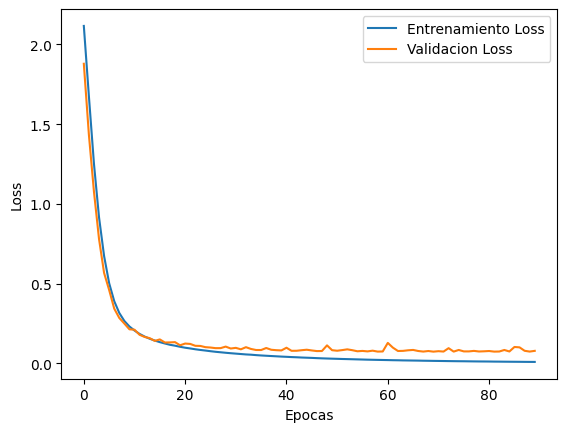

Training Accuracy: 0.9997


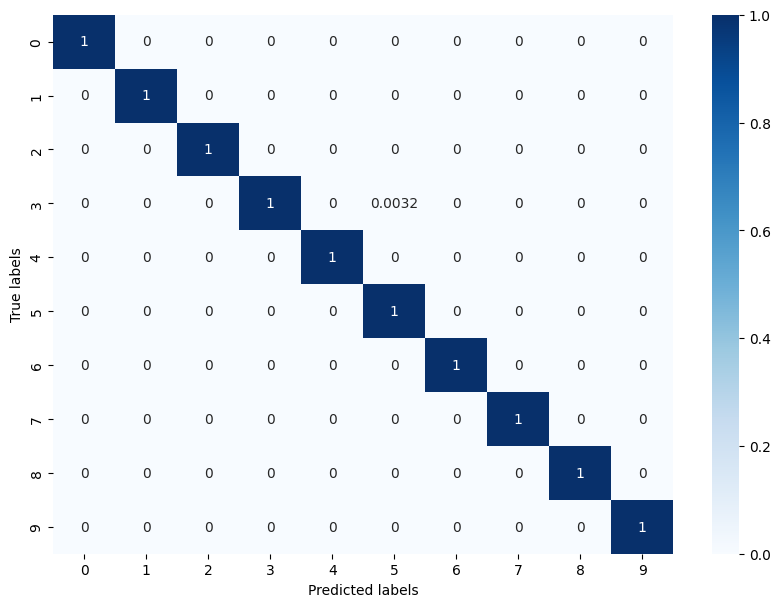

Validation Accuracy: 0.9747


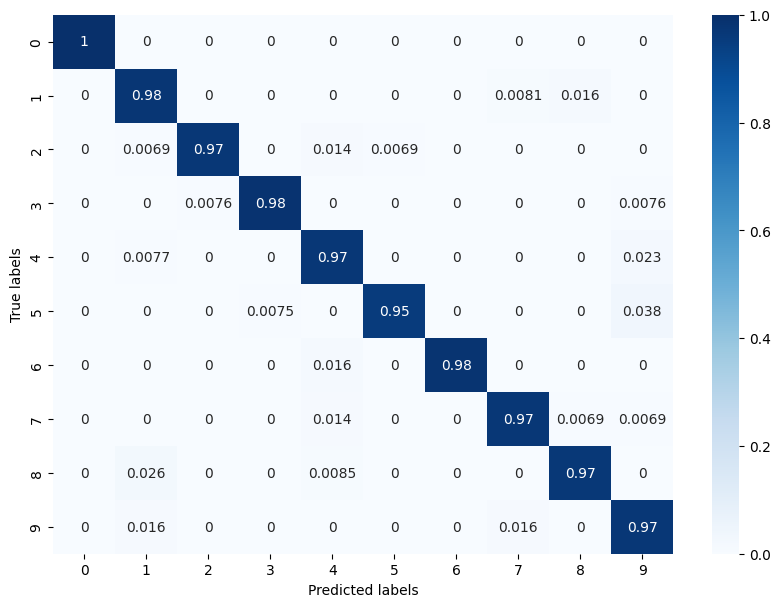

In [22]:
# (b) Graficamos el loss de entrenamiento y validación
plot_loss(train_losses_b, val_losses_b)

# (c) Generamos la matriz de confusión y accuracy para el conjunto de entrenamiento
cm_train, acc_train = compute_confusion_matrix_and_accuracy(model_b, dataloader_train)
print(f"Training Accuracy: {acc_train:.4f}")
plot_confusion_matrix(cm_train)

# (d) Generamos la matriz de confusión y accuracy para el conjunto de validación
cm_val, acc_val = compute_confusion_matrix_and_accuracy(model_b, dataloader_val)
print(f"Validation Accuracy: {acc_val:.4f}")
plot_confusion_matrix(cm_val)


Epoch 0, Train Loss: 2.2108, Train Accuracy: 0.2544, Val Loss: 2.0424, Val Accuracy: 0.4207
Epoch 1, Train Loss: 1.9375, Train Accuracy: 0.4905, Val Loss: 1.8011, Val Accuracy: 0.5900
Epoch 2, Train Loss: 1.7252, Train Accuracy: 0.6321, Val Loss: 1.6221, Val Accuracy: 0.6667
Epoch 3, Train Loss: 1.5518, Train Accuracy: 0.6966, Val Loss: 1.4563, Val Accuracy: 0.7241
Epoch 4, Train Loss: 1.4071, Train Accuracy: 0.7459, Val Loss: 1.3169, Val Accuracy: 0.7724
Epoch 5, Train Loss: 1.2792, Train Accuracy: 0.7955, Val Loss: 1.2023, Val Accuracy: 0.8284
Epoch 6, Train Loss: 1.1671, Train Accuracy: 0.8337, Val Loss: 1.1176, Val Accuracy: 0.8605
Epoch 7, Train Loss: 1.0636, Train Accuracy: 0.8573, Val Loss: 1.0016, Val Accuracy: 0.8812
Epoch 8, Train Loss: 0.9711, Train Accuracy: 0.8817, Val Loss: 0.9125, Val Accuracy: 0.8958
Epoch 9, Train Loss: 0.8881, Train Accuracy: 0.8925, Val Loss: 0.8444, Val Accuracy: 0.9019
Epoch 10, Train Loss: 0.8138, Train Accuracy: 0.9024, Val Loss: 0.7638, Val Accu

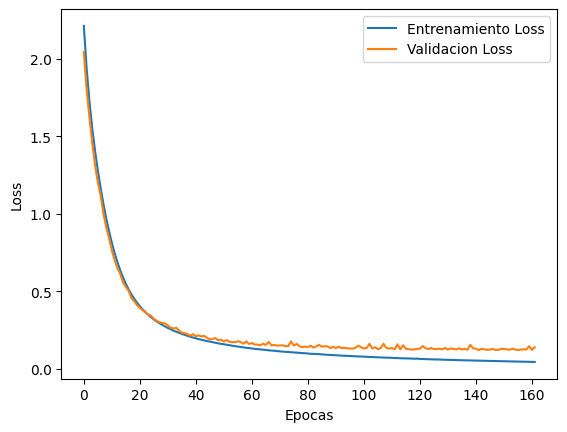

Training Accuracy: 0.9951


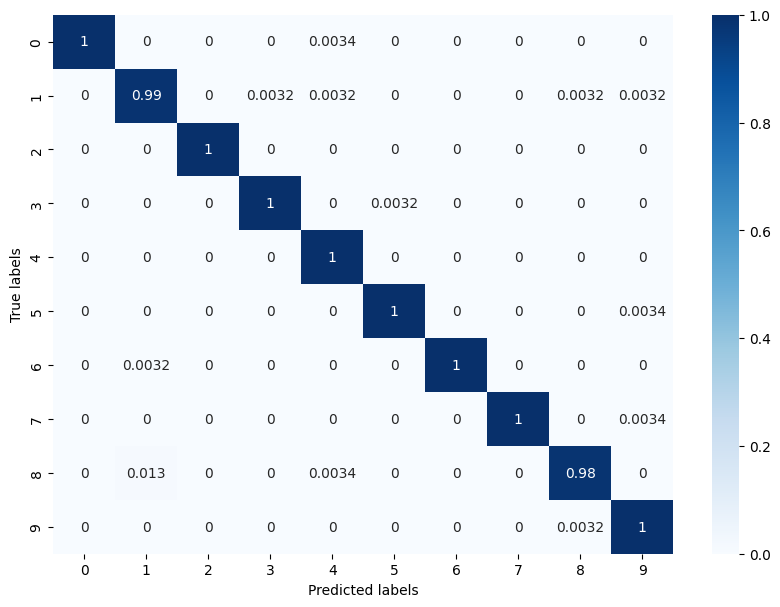

Validation Accuracy: 0.9663


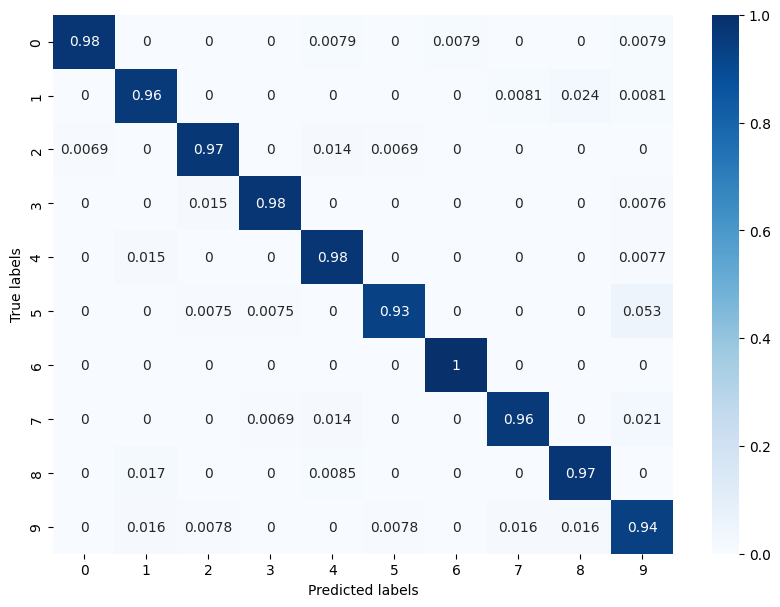

In [23]:
#PARTE C


train_losses_c = []
train_accuracies_c = []
val_losses_c = []
val_accuracies_c = []

# Definimos la red neuronal para el caso (c)
class NeuralNetC(nn.Module):
    def __init__(self):
        super(NeuralNetC, self).__init__()
        self.layer1 = nn.Linear(64, 10)
        self.tanh = nn.Tanh()
        self.layer2 = nn.Linear(10, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.tanh(x)
        x = self.layer2(x)
        return x

model_c = NeuralNetC().to(device)

# Entrenamos la red
optimizer = torch.optim.Adam(model_c.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

best_val_loss = float('inf')
epochs_no_improve = 0

start = time.time()

for epoch in range(num_epochs):

    train_loss = 0.0
    correct_train_preds = 0
    total_train_samples = 0
    # Entrenamiento
    model_c.train()
    for data in dataloader_train:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        optimizer.zero_grad()
        outputs = model_c(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        correct_train_preds += (preds == labels).sum().item()
        total_train_samples += labels.size(0)

    average_train_loss = train_loss / len(dataloader_train)
    train_accuracy = correct_train_preds / total_train_samples




    # Validación
    model_c.eval()
    val_loss = 0.0
    correct_val_preds = 0
    total_val_samples = 0
    with torch.no_grad():
        for data in dataloader_val:
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)
            outputs = model_c(inputs)
            _, preds = torch.max(outputs, 1)
            loss_val = criterion(outputs, labels)
            val_loss += loss_val.item()
            correct_val_preds += (preds == labels).sum().item()
            total_val_samples += labels.size(0)

    average_val_loss = val_loss / len(dataloader_val)
    val_accuracy = correct_val_preds / total_val_samples

    # Guardamos los resultados
    train_losses_c.append(average_train_loss)
    train_accuracies_c.append(train_accuracy)
    val_losses_c.append(average_val_loss)
    val_accuracies_c.append(val_accuracy)






    # Verificar si el loss de validación ha mejorado
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # Si el loss de validación no mejora durante 'patience' épocas, detener el entrenamiento
    if epochs_no_improve == patience:
        print(f"Early stopping at epoch {epoch}")
        break

    print(f'Epoch {epoch}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {average_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

end = time.time()
print('Entrenamiento finalizado, total tiempo %f seconds' % (end - start))

# (b) Graficar el loss de entrenamiento y validación
plot_loss(train_losses_c, val_losses_c)

# (c) Generar la matriz de confusión y accuracy para el conjunto de entrenamiento
cm_train, acc_train = compute_confusion_matrix_and_accuracy(model_c, dataloader_train)
print(f"Training Accuracy: {acc_train:.4f}")
plot_confusion_matrix(cm_train)

# (d) Generar la matriz de confusión y accuracy para el conjunto de validación
cm_val, acc_val = compute_confusion_matrix_and_accuracy(model_c, dataloader_val)
print(f"Validation Accuracy: {acc_val:.4f}")
plot_confusion_matrix(cm_val)

Epoch 0, Train Loss: 2.0516, Train Accuracy: 0.3988, Val Loss: 1.7543, Val Accuracy: 0.6222
Epoch 1, Train Loss: 1.5256, Train Accuracy: 0.7314, Val Loss: 1.3043, Val Accuracy: 0.7816
Epoch 2, Train Loss: 1.1337, Train Accuracy: 0.8228, Val Loss: 0.9683, Val Accuracy: 0.8513
Epoch 3, Train Loss: 0.8517, Train Accuracy: 0.8705, Val Loss: 0.7450, Val Accuracy: 0.8904
Epoch 4, Train Loss: 0.6588, Train Accuracy: 0.9001, Val Loss: 0.5786, Val Accuracy: 0.9203
Epoch 5, Train Loss: 0.5230, Train Accuracy: 0.9208, Val Loss: 0.4653, Val Accuracy: 0.9364
Epoch 6, Train Loss: 0.4285, Train Accuracy: 0.9333, Val Loss: 0.3800, Val Accuracy: 0.9387
Epoch 7, Train Loss: 0.3601, Train Accuracy: 0.9435, Val Loss: 0.3358, Val Accuracy: 0.9425
Epoch 8, Train Loss: 0.3111, Train Accuracy: 0.9507, Val Loss: 0.2907, Val Accuracy: 0.9487
Epoch 9, Train Loss: 0.2729, Train Accuracy: 0.9550, Val Loss: 0.2683, Val Accuracy: 0.9494
Epoch 10, Train Loss: 0.2437, Train Accuracy: 0.9576, Val Loss: 0.2379, Val Accu

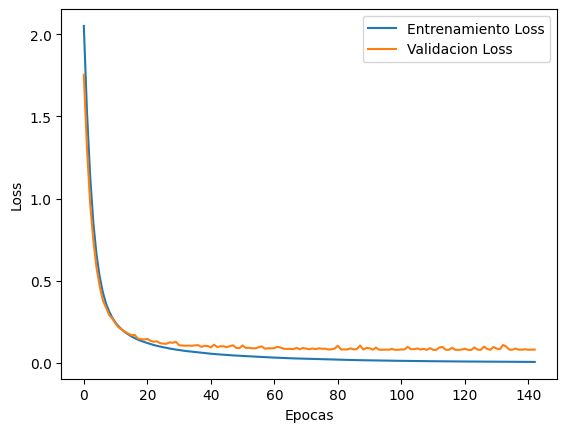

Training Accuracy: 1.0000


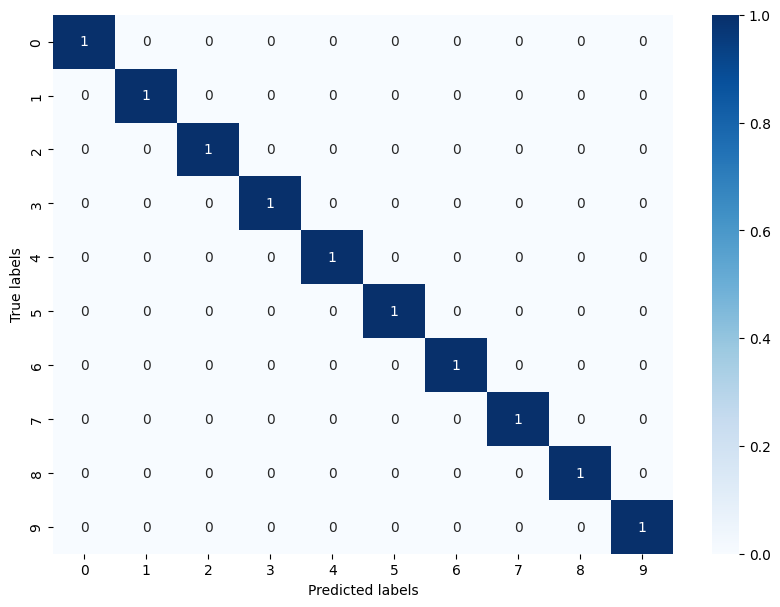

Validation Accuracy: 0.9724


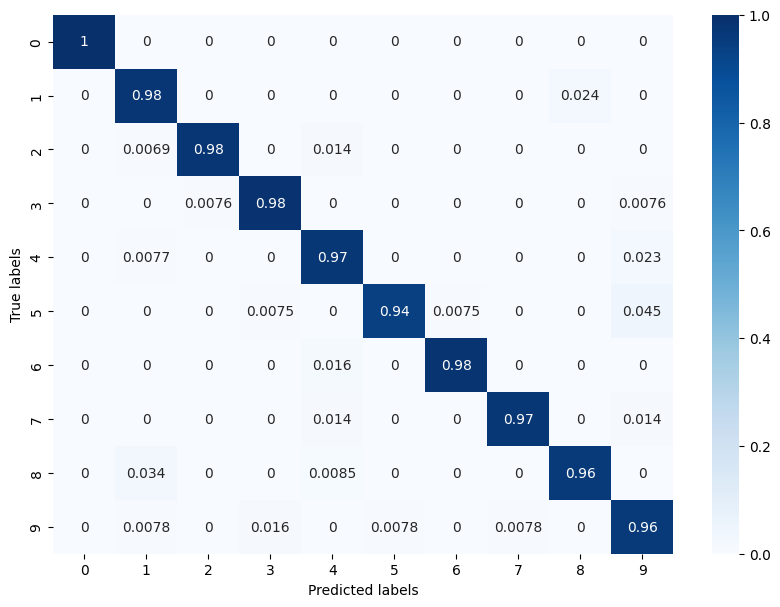

In [30]:
# D)

train_losses_d = []
train_accuracies_d = []
val_losses_d = []
val_accuracies_d = []

# Definimos la red neuronal para el caso (d)
class NeuralNetD(nn.Module):
    def __init__(self):
        super(NeuralNetD, self).__init__()
        self.layer1 = nn.Linear(64, 40)
        self.tanh = nn.Tanh()
        self.layer2 = nn.Linear(40, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.tanh(x)
        x = self.layer2(x)
        return x

model_d = NeuralNetD().to(device)

# Entrenamos la red
optimizer = torch.optim.Adam(model_d.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

best_val_loss = float('inf')
epochs_no_improve = 0

start = time.time()

for epoch in range(num_epochs):

    train_loss = 0.0
    correct_train_preds = 0
    total_train_samples = 0
    # Entrenamiento
    model_d.train()
    for data in dataloader_train:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        optimizer.zero_grad()
        outputs = model_d(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        correct_train_preds += (preds == labels).sum().item()
        total_train_samples += labels.size(0)

    average_train_loss = train_loss / len(dataloader_train)
    train_accuracy = correct_train_preds / total_train_samples

    # Validación
    model_d.eval()
    val_loss = 0.0
    correct_val_preds = 0
    total_val_samples = 0
    with torch.no_grad():
        for data in dataloader_val:
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)
            outputs = model_d(inputs)
            _, preds = torch.max(outputs, 1)
            loss_val = criterion(outputs, labels)
            val_loss += loss_val.item()
            correct_val_preds += (preds == labels).sum().item()
            total_val_samples += labels.size(0)

    average_val_loss = val_loss / len(dataloader_val)
    val_accuracy = correct_val_preds / total_val_samples

    # Guardamos los resultados
    train_losses_d.append(average_train_loss)
    train_accuracies_d.append(train_accuracy)
    val_losses_d.append(average_val_loss)
    val_accuracies_d.append(val_accuracy)

    # Verificar si el loss de validación ha mejorado
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # Si el loss de validación no mejora durante 'patience' épocas, detener el entrenamiento
    if epochs_no_improve == patience:
        print(f"Early stopping at epoch {epoch}")
        break

    print(f'Epoch {epoch}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {average_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

end = time.time()
print('Finished Training, total time %f seconds' % (end - start))

# (b) Graficamos el loss de entrenamiento y validación
plot_loss(train_losses_d, val_losses_d)

# (c) Generamos la matriz de confusión y accuracy para el conjunto de entrenamiento
cm_train, acc_train = compute_confusion_matrix_and_accuracy(model_d, dataloader_train)
print(f"Training Accuracy: {acc_train:.4f}")
plot_confusion_matrix(cm_train)

# (d) Generamos la matriz de confusión y accuracy para el conjunto de validación
cm_val, acc_val = compute_confusion_matrix_and_accuracy(model_d, dataloader_val)
print(f"Validation Accuracy: {acc_val:.4f}")
plot_confusion_matrix(cm_val)


Epoch 0, Train Loss: 2.2978, Train Accuracy: 0.0943, Val Loss: 2.2700, Val Accuracy: 0.1180
Epoch 1, Train Loss: 2.2211, Train Accuracy: 0.1782, Val Loss: 2.1782, Val Accuracy: 0.2720
Epoch 2, Train Loss: 2.0907, Train Accuracy: 0.3182, Val Loss: 2.0333, Val Accuracy: 0.3433
Epoch 3, Train Loss: 1.9055, Train Accuracy: 0.3547, Val Loss: 1.8535, Val Accuracy: 0.3533
Epoch 4, Train Loss: 1.7045, Train Accuracy: 0.4089, Val Loss: 1.6590, Val Accuracy: 0.4352
Epoch 5, Train Loss: 1.5018, Train Accuracy: 0.5434, Val Loss: 1.4356, Val Accuracy: 0.6061
Epoch 6, Train Loss: 1.2848, Train Accuracy: 0.6775, Val Loss: 1.2361, Val Accuracy: 0.7080
Epoch 7, Train Loss: 1.0825, Train Accuracy: 0.7393, Val Loss: 1.0372, Val Accuracy: 0.7556
Epoch 8, Train Loss: 0.9031, Train Accuracy: 0.7765, Val Loss: 0.8714, Val Accuracy: 0.7847
Epoch 9, Train Loss: 0.7579, Train Accuracy: 0.8021, Val Loss: 0.7352, Val Accuracy: 0.8192
Epoch 10, Train Loss: 0.6450, Train Accuracy: 0.8294, Val Loss: 0.6217, Val Accu

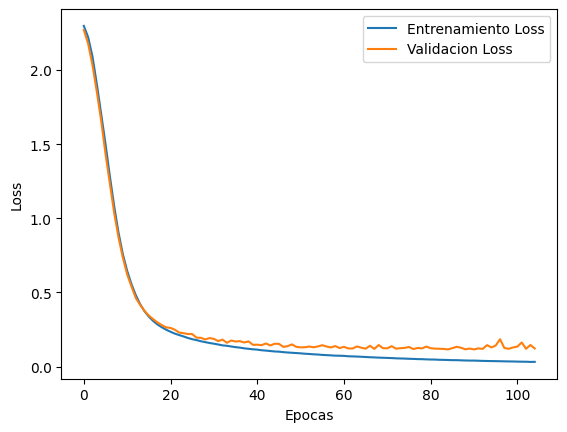

Training Accuracy: 0.9947


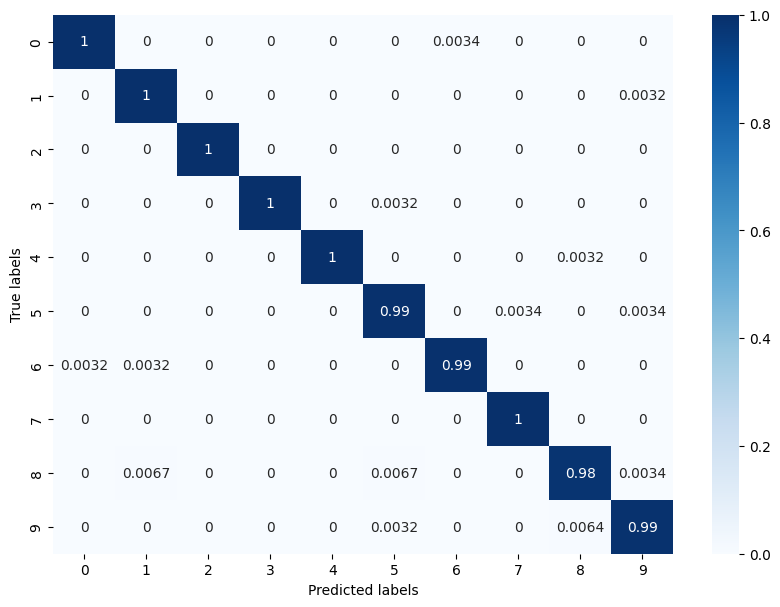

Validation Accuracy: 0.9632


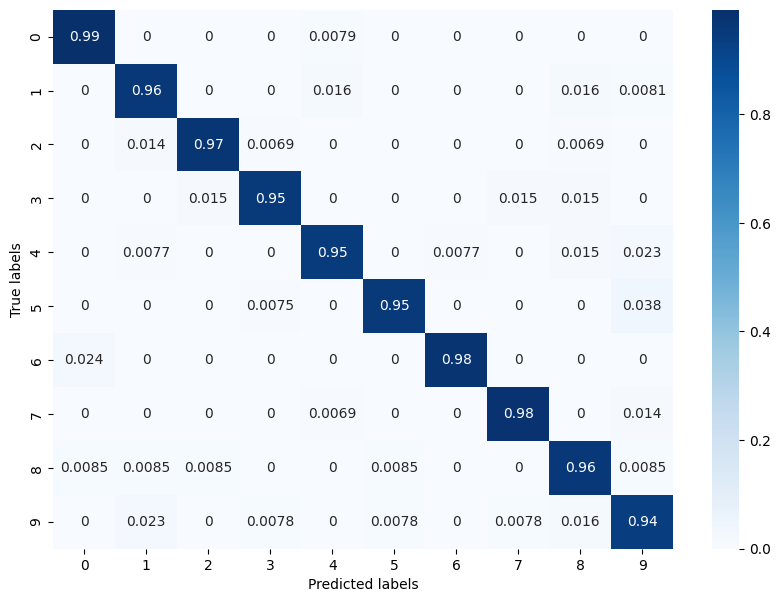

In [31]:
# E)

train_losses_e = []
train_accuracies_e = []
val_losses_e = []
val_accuracies_e = []


# Definimos la red neuronal para el caso (e)
class NeuralNetE(nn.Module):
    def __init__(self):
        super(NeuralNetE, self).__init__()
        self.layer1 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(10, 10)
        self.layer3 = nn.Linear(10, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        return x

model_e = NeuralNetE().to(device)

# Entrenamos la red
optimizer = torch.optim.Adam(model_e.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

best_val_loss = float('inf')
epochs_no_improve = 0

start = time.time()

for epoch in range(num_epochs):

    train_loss = 0.0
    correct_train_preds = 0
    total_train_samples = 0
    # Entrenamiento
    model_e.train()
    for data in dataloader_train:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        optimizer.zero_grad()
        outputs = model_e(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        correct_train_preds += (preds == labels).sum().item()
        total_train_samples += labels.size(0)

    average_train_loss = train_loss / len(dataloader_train)
    train_accuracy = correct_train_preds / total_train_samples

    # Validación
    model_e.eval()
    val_loss = 0.0
    correct_val_preds = 0
    total_val_samples = 0
    with torch.no_grad():
        for data in dataloader_val:
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)
            outputs = model_e(inputs)
            _, preds = torch.max(outputs, 1)
            loss_val = criterion(outputs, labels)
            val_loss += loss_val.item()
            correct_val_preds += (preds == labels).sum().item()
            total_val_samples += labels.size(0)

    average_val_loss = val_loss / len(dataloader_val)
    val_accuracy = correct_val_preds / total_val_samples

    # Guardamos los resultados
    train_losses_e.append(average_train_loss)
    train_accuracies_e.append(train_accuracy)
    val_losses_e.append(average_val_loss)
    val_accuracies_e.append(val_accuracy)

    # Verificar si el loss de validación ha mejorado
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # Si el loss de validación no mejora durante 'patience' épocas, detener el entrenamiento
    if epochs_no_improve == patience:
        print(f"Early stopping at epoch {epoch}")
        break

    print(f'Epoch {epoch}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {average_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

end = time.time()
print('Entrenamiento finalizado, total tiempo %f seconds' % (end - start))

# Graficamos el loss de entrenamiento y validación
plot_loss(train_losses_e, val_losses_e)

# Generamos la matriz de confusión y accuracy para el conjunto de entrenamiento
cm_train, acc_train = compute_confusion_matrix_and_accuracy(model_e, dataloader_train)
print(f"Training Accuracy: {acc_train:.4f}")
plot_confusion_matrix(cm_train)

# Generamos la matriz de confusión y accuracy para el conjunto de validación
cm_val, acc_val = compute_confusion_matrix_and_accuracy(model_e, dataloader_val)
print(f"Validation Accuracy: {acc_val:.4f}")
plot_confusion_matrix(cm_val)


Epoch 0, Train Loss: 2.1917, Train Accuracy: 0.2811, Val Loss: 2.0409, Val Accuracy: 0.4713
Epoch 1, Train Loss: 1.8145, Train Accuracy: 0.6213, Val Loss: 1.5226, Val Accuracy: 0.7257
Epoch 2, Train Loss: 1.2108, Train Accuracy: 0.7801, Val Loss: 0.9014, Val Accuracy: 0.8138
Epoch 3, Train Loss: 0.6889, Train Accuracy: 0.8642, Val Loss: 0.5181, Val Accuracy: 0.8966
Epoch 4, Train Loss: 0.4017, Train Accuracy: 0.9139, Val Loss: 0.3317, Val Accuracy: 0.9333
Epoch 5, Train Loss: 0.2732, Train Accuracy: 0.9339, Val Loss: 0.2344, Val Accuracy: 0.9402
Epoch 6, Train Loss: 0.2076, Train Accuracy: 0.9467, Val Loss: 0.1992, Val Accuracy: 0.9464
Epoch 7, Train Loss: 0.1684, Train Accuracy: 0.9569, Val Loss: 0.1665, Val Accuracy: 0.9517
Epoch 8, Train Loss: 0.1433, Train Accuracy: 0.9635, Val Loss: 0.1462, Val Accuracy: 0.9556
Epoch 9, Train Loss: 0.1254, Train Accuracy: 0.9684, Val Loss: 0.1333, Val Accuracy: 0.9579
Epoch 10, Train Loss: 0.1106, Train Accuracy: 0.9724, Val Loss: 0.1249, Val Accu

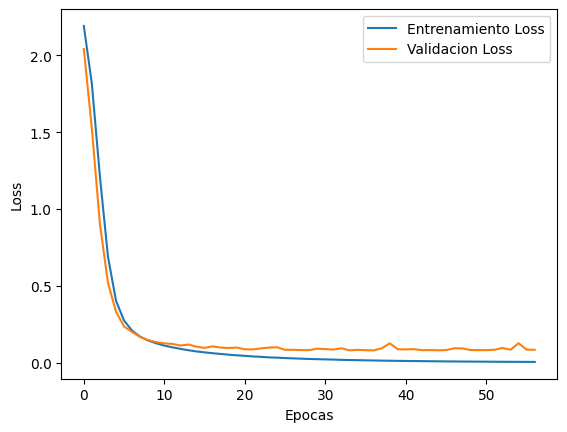

Training Accuracy: 1.0000


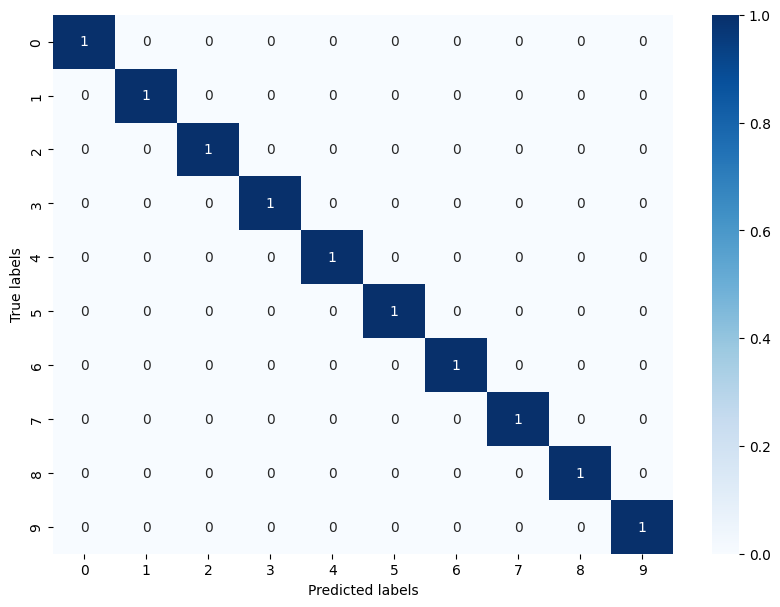

Validation Accuracy: 0.9747


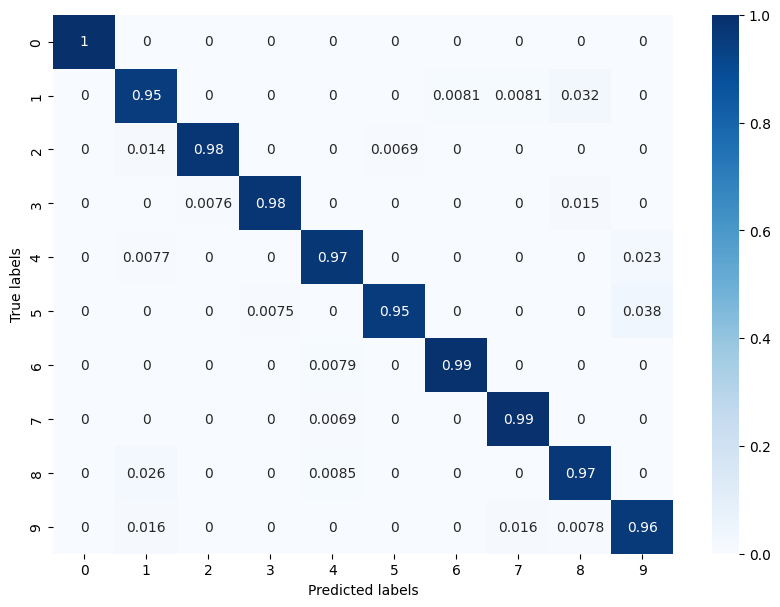

In [32]:
# F)

train_losses_f = []
train_accuracies_f = []
val_losses_f = []
val_accuracies_f = []

# Definimos la red neuronal para el caso (f)
class NeuralNetF(nn.Module):
    def __init__(self):
        super(NeuralNetF, self).__init__()
        self.layer1 = nn.Linear(64, 40)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(40, 40)
        self.layer3 = nn.Linear(40, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        return x

model_f = NeuralNetF().to(device)

# Entrenamos la red
optimizer = torch.optim.Adam(model_f.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

best_val_loss = float('inf')
epochs_no_improve = 0

start = time.time()

for epoch in range(num_epochs):

    train_loss = 0.0
    correct_train_preds = 0
    total_train_samples = 0
    # Entrenamiento
    model_f.train()
    for data in dataloader_train:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        optimizer.zero_grad()
        outputs = model_f(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        correct_train_preds += (preds == labels).sum().item()
        total_train_samples += labels.size(0)

    average_train_loss = train_loss / len(dataloader_train)
    train_accuracy = correct_train_preds / total_train_samples

    # Validación
    model_f.eval()
    val_loss = 0.0
    correct_val_preds = 0
    total_val_samples = 0
    with torch.no_grad():
        for data in dataloader_val:
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)
            outputs = model_f(inputs)
            _, preds = torch.max(outputs, 1)
            loss_val = criterion(outputs, labels)
            val_loss += loss_val.item()
            correct_val_preds += (preds == labels).sum().item()
            total_val_samples += labels.size(0)

    average_val_loss = val_loss / len(dataloader_val)
    val_accuracy = correct_val_preds / total_val_samples

    # Guardamos los resultados
    train_losses_f.append(average_train_loss)
    train_accuracies_f.append(train_accuracy)
    val_losses_f.append(average_val_loss)
    val_accuracies_f.append(val_accuracy)

    # Verificar si el loss de validación ha mejorado
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # Si el loss de validación no mejora durante 'patience' épocas, detener el entrenamiento
    if epochs_no_improve == patience:
        print(f"Early stopping at epoch {epoch}")
        break

    print(f'Epoch {epoch}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {average_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

end = time.time()
print('Entrenamiento finalizado, total tiempo %f seconds' % (end - start))

# Graficamos el loss de entrenamiento y validación
plot_loss(train_losses_f, val_losses_f)

# Generamos la matriz de confusión y accuracy para el conjunto de entrenamiento
cm_train, acc_train = compute_confusion_matrix_and_accuracy(model_f, dataloader_train)
print(f"Training Accuracy: {acc_train:.4f}")
plot_confusion_matrix(cm_train)

# Generamos la matriz de confusión y accuracy para el conjunto de validación
cm_val, acc_val = compute_confusion_matrix_and_accuracy(model_f, dataloader_val)
print(f"Validation Accuracy: {acc_val:.4f}")
plot_confusion_matrix(cm_val)


In [33]:
#PARTE 3



final_accuracy_a = val_accuracies_a[-1]
final_accuracy_b = val_accuracies_b[-1]
final_accuracy_c = val_accuracies_c[-1]
final_accuracy_d = val_accuracies_d[-1]
final_accuracy_e = val_accuracies_e[-1]
final_accuracy_f = val_accuracies_f[-1]

# Encuentra el modelo con la mayor accuracy al final del entrenamiento
best_model_accuracy = max(final_accuracy_a, final_accuracy_b, final_accuracy_c,
                          final_accuracy_d, final_accuracy_e, final_accuracy_f)

best_model = None

if best_model_accuracy == final_accuracy_a:
    best_model = model_a
    print("El mejor modelo es (a)")
elif best_model_accuracy == final_accuracy_b:
    best_model = model_b
    print("El mejor modelo es (b)")
elif best_model_accuracy == final_accuracy_c:
    best_model = model_c
    print("El mejor modelo es (c)")
elif best_model_accuracy == final_accuracy_d:
    best_model = model_d
    print("El mejor modelo es (d)")
elif best_model_accuracy == final_accuracy_e:
    best_model = model_e
    print("El mejor modelo es (e)")
else:
    best_model = model_f
    print("El mejor modelo es (f)")

print(f"Con una accuracy de validación de: {best_model_accuracy:.4f}")


El mejor modelo es (b)
Con una accuracy de validación de: 0.9747


Test Accuracy: 0.9811


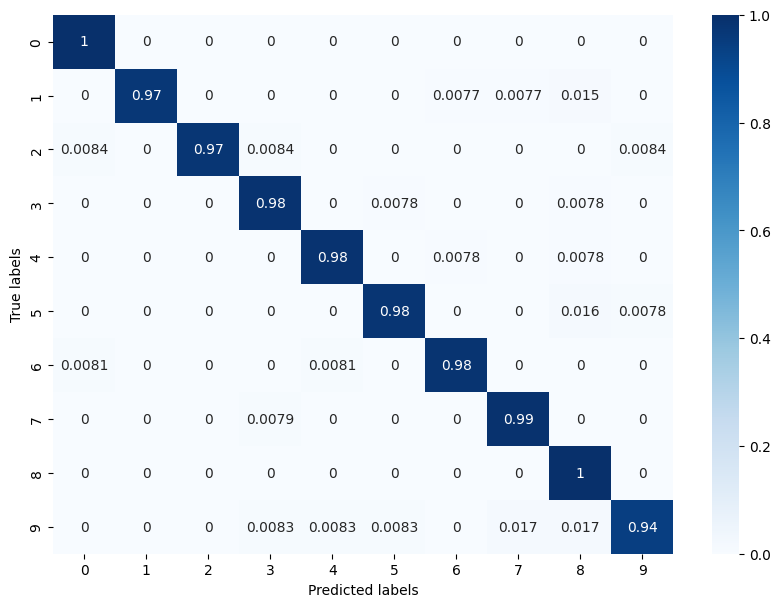

In [ ]:
# Asegurarnos de que el modelo esté en modo de evaluación y en el dispositivo correcto
model_b = model_b.eval().to(device)

# Inicializamos las variables necesarias para el cálculo
correct_preds = 0
total_samples = 0
cm_array = np.zeros((10, 10))  # Cambiado el nombre aquí

# Evaluamos el modelo en el conjunto de prueba
with torch.no_grad():
    for data in dataloader_test:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model_b(inputs)
        _, preds = torch.max(outputs, 1)

        # Actualizamos la matriz de confusión
        for t, p in zip(labels.view(-1), preds.view(-1)):
            cm_array[t.long(), p.long()] += 1  # Y aquí igual

        correct_preds += (preds == labels).sum().item()
        total_samples += labels.size(0)

# Generamos la matriz de confusión y accuracy para el conjunto de prueba
cm_test, acc_test = compute_confusion_matrix_and_accuracy(model_b, dataloader_test)
print(f"Test Accuracy: {acc_test:.4f}")
plot_confusion_matrix(cm_test)
